<a href="https://www.kaggle.com/ritvik1909/named-entity-recognition?scriptVersionId=69641813" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style('darkgrid')

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

## Approaches to NER
* **Classical Approaches:** mostly rule-based.
* **Machine Learning Approaches:** there are two main methods in this category: 
    * Treat the problem as a multi-class classification where named entities are our labels so we can apply different classification algorithms. The problem here is that identifying and labeling named entities require thorough understanding of the context of a sentence and sequence of the word labels in it, which this method ignores that.
    * Conditional Random Field (CRF) model. It is a probabilistic graphical model that can be used to model sequential data such as labels of words in a sentence. The CRF model is able to capture the features of the current and previous labels in a sequence but it cannot understand the context of the forward labels; this shortcoming plus the extra feature engineering involved with training a CRF model, makes it less appealing to be adapted by the industry.
* **Deep Learning Approaches:** Bidirectional RNNs

# EDA

In [2]:
data = pd.read_csv(
    "../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False, 
    usecols=['sentence_idx', 'word', 'tag']
)
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
print(data.shape)
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


Number of Sentences: 36684
Maximum sequence length: 140
Number of unique words: 30172


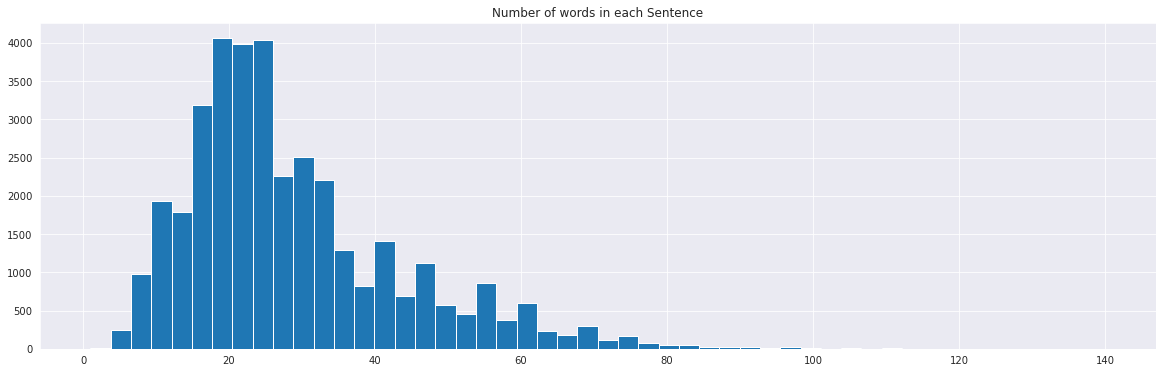

In [3]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(data['sentence_idx'].value_counts().values, bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = np.max(data['sentence_idx'].value_counts().values)
print('Number of Sentences:', data['sentence_idx'].nunique())
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


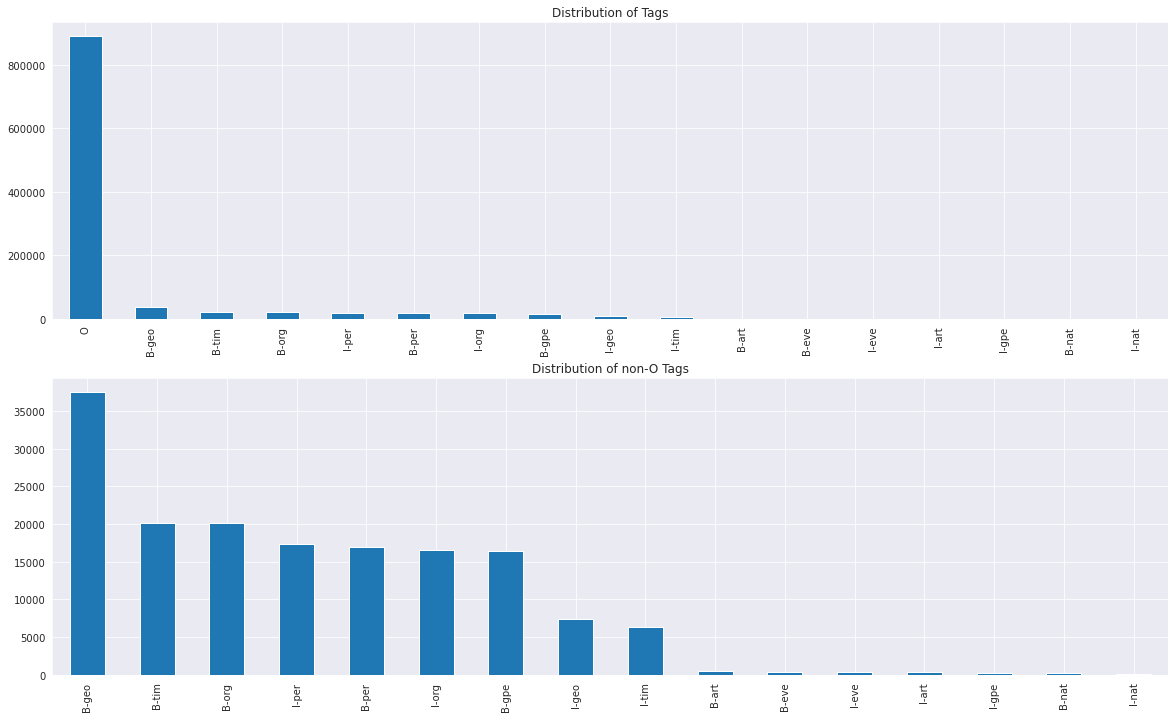

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

# Preprocessing

In [5]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras import layers as L
from tensorflow.keras import models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [6]:
transformer = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(transformer)
encoder = TFAutoModel.from_pretrained(transformer)

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [7]:
from sklearn.preprocessing import LabelEncoder

tag_encoder = LabelEncoder()
data['tag'] = tag_encoder.fit_transform(data['tag'])
sentences = data.groupby("sentence_idx")["word"].apply(list).values
tags = data.groupby("sentence_idx")["tag"].apply(list).values

In [8]:
dataset_dict = {
    "input_ids": [],
    "attention_mask": [],
    "tags": []
}

for sentence, tag in tqdm(zip(sentences, tags)):
    input_ids = []
    target_tags = []
    for idx, word in enumerate(sentence):
        ids = tokenizer.encode(word, add_special_tokens=False)
        input_ids.extend(ids)
        num_tokens = len(ids)
        target_tags.extend([tag[idx]] * num_tokens)

    input_ids = input_ids[:maxlen - 2]
    target_tags = target_tags[:maxlen - 2]

    input_ids = [101] + input_ids + [102]
    target_tags = [n_tags-1] + target_tags + [n_tags-1]
    attention_mask = [1] * len(input_ids)
    padding_len = maxlen - len(input_ids)

    input_ids = input_ids + ([0] * padding_len)
    attention_mask = attention_mask + ([0] * padding_len)
    target_tags = target_tags + ([n_tags] * padding_len)

    dataset_dict["input_ids"].append(input_ids)
    dataset_dict["attention_mask"].append(attention_mask)
    dataset_dict["tags"].append(target_tags)
    assert len(target_tags) == maxlen, f'{len(input_ids)}, {len(target_tags)}'

In [9]:
for key in dataset_dict:
    dataset_dict[key] = np.array(dataset_dict[key])

X = [
    dataset_dict["input_ids"],
    dataset_dict["attention_mask"],
]
y = to_categorical(dataset_dict["tags"])

# Modelling

In [10]:
input_ids = L.Input(shape=(maxlen,), dtype=tf.int32)
attention_mask = L.Input(shape=(maxlen,), dtype=tf.int32)
embedding = encoder.distilbert([input_ids, attention_mask])[0]
embedding = L.Dropout(0.3)(embedding)
# embedding = L.Dense(128, activation='relu')(embedding)
tag_logits = L.TimeDistributed(L.Dense(n_tags+1, activation='softmax'))(embedding)

model = models.Model(
    inputs=[input_ids,  attention_mask],
    outputs=[tag_logits],
)
model.compile(optimizer=optimizers.Adam(lr=3e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay ((None, 140, 768),)  65190912    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 140, 768)     0           distilbert[0][0]      

In [11]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=1e-4)
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1)

history = model.fit(x=X, y=y, validation_split=0.1, callbacks=[es, rlp], epochs=10)

Epoch 1/10
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0244 - val_accuracy: 0.9926
Epoch 3/10
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0238 - accuracy: 0.9923 - val_loss: 0.0223 - val_accuracy: 0.9932
Epoch 4/10
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.0222 - val_accuracy: 0.9934
Epoch 5/10
1032/1032 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9955
Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
1032/1032 [==============================] - 275s 267ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.0228 - val_accuracy: 0.9939
Epoch 6/10
1032/1032 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9973
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999998787388907e-07.
1032/1032 [==============================] - 275s 267ms/step 

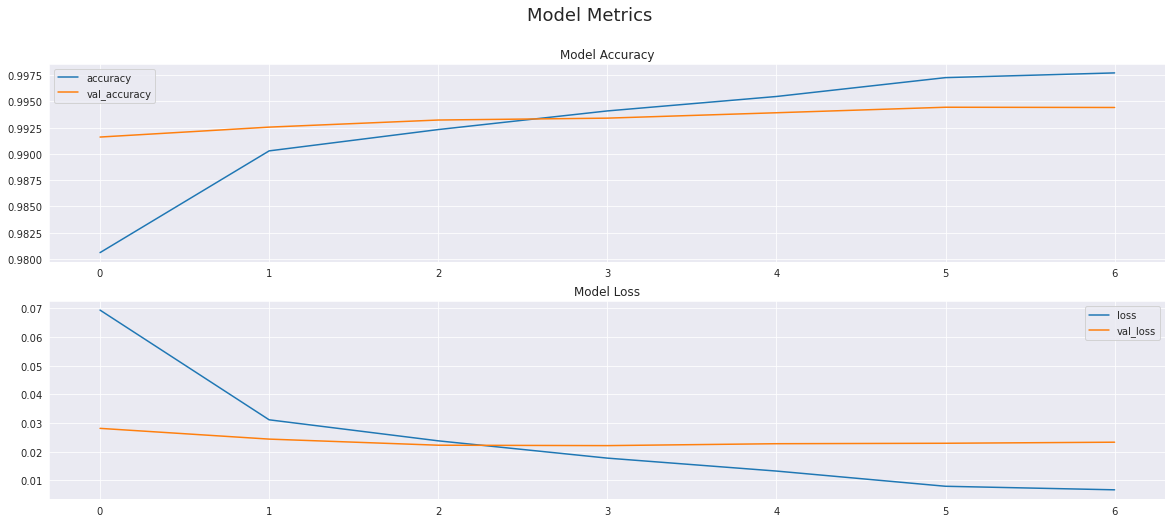

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [13]:
i = 182#np.random.randint(0, len(X[0]))
p = model.predict([[X[0][i], X[1][i]]])
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}{'True':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[0][i], y_true, p):
    print(f"{tokenizer.convert_ids_to_tokens(int(w)):15} {tag_encoder.inverse_transform([t])[0]}\t{tag_encoder.inverse_transform(pred)[0]}")
    if w == 102: 
        break

Word           True 	Pred
------------------------------
[CLS]           O	O
Speaking        O	O
to              O	O
ABC             B-org	O
News            I-org	O
interview       O	O
##er            O	O
Di              B-per	O
##anne          B-per	O
Sawyer          I-per	O
,               O	O
the             O	O
25              O	I-tim
-               O	O
year            O	O
-               O	O
old             O	O
co              O	O
-               O	O
star            O	O
of              O	O
TV              O	O
'               O	O
s               O	O
The             B-art	O
Simple          I-art	O
Life            I-art	O
said            O	O
she             O	O
is              O	O
almost          O	O
four            O	O
months          O	O
along           O	O
in              O	O
her             O	O
pregnancy       O	O
.               O	O
[SEP]           O	B-nat
